In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# data.txt dosyasından verileri yükle
file_path = "C:/Users/alica/Desktop/1k_data.txt"
data = pd.read_csv(file_path, header=None, names=["M", "Peri", "Node", "Incl.", "E", "N", "A", "Epoch"], sep="_")

# Gelecekteki pozisyonu (Future_Position) rastgele değerlerle dolduralım
data["Future_Position"] = np.random.uniform(2.0, 3.5, size=len(data))

# Özellikleri (features) ve hedef değeri (target) ayır
X = data[["M", "Peri", "Node", "Incl.", "E", "N", "A", "Epoch"]].values
y = data["Future_Position"].values

# Veriyi eğitim ve test setlerine ayır (%80 eğitim, %20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Veriyi ölçeklendir
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Veriyi PyTorch tensörlerine dönüştür
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# PyTorch DataLoader ile veri kümelerini oluştur
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2)

# PyTorch modeli oluştur
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNN()

# Kayıp fonksiyonu ve optimizasyon
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Modeli eğit
epochs = 100
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Test seti üzerinde değerlendirme
model.eval()
with torch.no_grad():
    test_loss = 0.0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
    test_loss /= len(test_loader)
    print(f"Test seti üzerinde ortalama kayıp değeri: {test_loss:.4f}")

# Yeni bir epoch değeri için gelecekteki konumu tahmin et
new_data = pd.DataFrame([[145.849, 73.285, 80.254, 10.587, 0.079, 0.214, 2.766, 20250101]],
                        columns=["M", "Peri", "Node", "Incl.", "E", "N", "A", "Epoch"])
new_data_scaled = scaler.transform(new_data)
new_data_tensor = torch.tensor(new_data_scaled, dtype=torch.float32)

model.eval()
with torch.no_grad():
    predicted_position = model(new_data_tensor)
    print(f"Gelecek konum tahmini: {predicted_position.item()}")


gpusuz çalışan egitme modeli yukarıdaki

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import time

# Cihazı ayarlayın (GPU varsa CUDA, yoksa CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

# Veri yükleme
file_path = "C:/Users/alica/Desktop/10k_data.txt"
data = pd.read_csv(file_path, header=None, names=["M", "Peri", "Node", "Incl.", "E", "N", "A", "Epoch"], sep="_")

# Gelecekteki pozisyonu (Future_Position) rastgele değerlerle dolduralım
data["Future_Position"] = np.random.uniform(2.0, 3.5, size=len(data))

# Özellikleri (features) ve hedef değeri (target) ayır
X = data[["M", "Peri", "Node", "Incl.", "E", "N", "A", "Epoch"]].values
y = data["Future_Position"].values

# Veriyi eğitim ve test setlerine ayır (%70 eğitim, %30 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Veriyi ölçeklendir
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Veriyi PyTorch tensörlerine dönüştür ve GPU'ya taşı
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device).view(-1, 1)

# PyTorch DataLoader ile veri kümelerini oluştur
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Veri yükleyicileri
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=512, num_workers=4)

# Modeli oluştur
class ComplexNN(nn.Module):
    def __init__(self):
        super(ComplexNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = ComplexNN().to(device)

# Optimizasyon ve düzenlileştirme
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()  # Mixed precision için GradScaler

# Eğitim döngüsü
epochs = 100
start_time = time.time()
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():  # Mixed precision kullanımı
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    if (epoch + 1) % (epochs // 10) == 0:
        print(f"%{(epoch + 1) / epochs * 100:.0f} tamamlandı - Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
end_time = time.time()
print(f"Eğitim süresi: {end_time - start_time:.2f} saniye")

# Test seti üzerinde değerlendirme
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()
test_loss /= len(test_loader)
print(f"Test seti üzerinde ortalama kayıp değeri: {test_loss:.4f}")

# Yeni bir epoch değeri için gelecekteki konumu tahmin et
new_data = pd.DataFrame([[145.849, 73.285, 80.254, 10.587, 0.079, 0.214, 2.766, 20250101]],
                        columns=["M", "Peri", "Node", "Incl.", "E", "N", "A", "Epoch"])

# `new_data`'yı numpy array'e dönüştür
new_data_scaled = scaler.transform(new_data.values)
new_data_tensor = torch.tensor(new_data_scaled, dtype=torch.float32, device=device)

model.eval()
with torch.no_grad():
    predicted_position = model(new_data_tensor)
    print(f"Gelecek konum tahmini: {predicted_position.item()}")


yukarıdaki method son gpu ve cpu kullanımı arttırılmış deneme bunun ustunden duzenlenıcek

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Cihazı ayarlayın (GPU varsa CUDA, yoksa CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

# Veriyi yükle
file_path = "C:/Users/alica/Desktop/1k_data.txt"
data = pd.read_csv(file_path, header=None, names=["M", "Peri", "Node", "Incl.", "E", "N", "A", "Epoch"], sep="_")

# Gelecekteki pozisyonu (Future_Position) rastgele değerlerle dolduralım
data["Future_Position"] = np.random.uniform(2.0, 3.5, size=len(data))

# Özellikleri (features) ve hedef değeri (target) ayır
X = data[["M", "Peri", "Node", "Incl.", "E", "N", "A", "Epoch"]].values
y = data["Future_Position"].values

# Veriyi eğitim ve test setlerine ayır (%80 eğitim, %20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Veriyi ölçeklendir
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Veriyi PyTorch tensörlerine dönüştür ve GPU'ya taşı
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device).view(-1, 1)

# PyTorch DataLoader ile veri kümelerini oluştur
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=8)

# Modeli oluştur
class DropoutNN(nn.Module):
    def __init__(self):
        super(DropoutNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 32)
        self.fc2 = nn.Linear(32, 16)
        self.dropout = nn.Dropout(0.3)  # %30 düğüm kapatılacak
        self.fc3 = nn.Linear(16, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

model = DropoutNN().to(device)

# Optimizasyon ve düzenlileştirme
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Eğitim döngüsü
epochs = 100
best_loss = float('inf')
patience = 5
counter = 0

print("Eğitim başlıyor...")
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Test seti üzerinde doğrulama
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
    val_loss /= len(test_loader)

    # Erken durdurma kontrolü
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Erken durdurma uygulandı.")
            break

    print(f"Epoch [{epoch+1}/{epochs}], Val Loss: {val_loss:.4f}")

print("Eğitim tamamlandı.")

# Test seti üzerinde değerlendirme
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()
test_loss /= len(test_loader)
print(f"Test seti üzerinde ortalama kayıp değeri: {test_loss:.4f}")

# Yeni bir epoch değeri için gelecekteki konumu tahmin et
new_data = pd.DataFrame([[145.849, 73.285, 80.254, 10.587, 0.079, 0.214, 2.766, 20250101]],
                        columns=["M", "Peri", "Node", "Incl.", "E", "N", "A", "Epoch"])
new_data_scaled = scaler.transform(new_data)
new_data_tensor = torch.tensor(new_data_scaled, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    predicted_position = model(new_data_tensor)
    print(f"Gelecek konum tahmini: {predicted_position.item()}")


böyle yukarıda gibi kod çok yavaş çalışıyordu, değiştireilin şeyler şunlar.
Harika, hızın ciddi anlamda artmasına sevindim! Yaptığımız değişikliklerin etkisini açıklayayım:

---

### **Yaptığım Değişiklikler ve Etkileri**

#### **1. Verilerin Baştan GPU'ya Taşınması**
Değişiklik:
```python
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device).view(-1, 1)
```

**Neden?**
- Daha önce, her batch'te veriler CPU'dan GPU'ya taşınıyordu. Bu işlem zaman alıyor ve GPU’nun tam kapasite çalışmasını engelliyordu.
- Bu değişiklikle, tüm veriler eğitimden önce GPU’ya taşındı. Böylece GPU’ya sürekli veri aktarımı yapılması gerekmedi.

**Etkisi:**
- GPU'yu daha verimli kullandık ve veri aktarımındaki darboğazı ortadan kaldırdık.
- İşlem süreleri belirgin şekilde azaldı.

---

#### **2. `pin_memory` ve `num_workers` Ayarlarının Optimize Edilmesi**
Değişiklik:
```python
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=256, num_workers=0)
```

**Neden?**
- `pin_memory=True` ve `num_workers>0`, verileri CPU’dan GPU’ya taşırken faydalı olabilir. Ancak veriler zaten GPU’da olduğu için bu ayarlar artık gereksizdi.
- `num_workers=0` ile CPU işlemlerini en aza indirdik.

**Etkisi:**
- GPU, veri aktarımıyla uğraşmadan tamamen model hesaplamalarına odaklandı.
- CPU ve GPU arasındaki senkronizasyon gecikmeleri azaldı.

---

#### **3. Daha Büyük Batch Boyutu**
Değişiklik:
```python
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)
```

**Neden?**
- RTX 4060 Max-Q gibi modern GPU’lar büyük batch boyutlarını destekler. Batch boyutunu artırmak, GPU’nun paralel işlem kapasitesinden daha fazla yararlanmamızı sağladı.
- Daha önce kullanılan küçük batch boyutları, GPU’nun potansiyelini tam olarak kullanamıyordu.

**Etkisi:**
- GPU daha fazla veri üzerinde aynı anda çalışabildi.
- Eğitim döngüsü başına işlem sayısı azaldı, bu da toplam süreyi düşürdü.

---

#### **4. Kodun Temizlenmesi ve Fazlalıkların Kaldırılması**
Değişiklik:
- `pin_memory`, `with torch.no_grad()` gibi gereksiz kısımlar optimize edildi.
- Daha az karmaşa, veri aktarımında ve eğitim döngüsünde gereksiz işlemleri ortadan kaldırdı.

**Neden?**
- Basit ve optimize edilmiş bir kod, gereksiz işlemleri azaltır ve hataları önler.

**Etkisi:**
- Daha temiz ve verimli bir eğitim süreci.

---

### **Sonuç**
Bu değişikliklerle:
1. **GPU’nun tam kapasitede çalışması sağlandı.**
2. **CPU ve GPU arasındaki senkronizasyon gecikmeleri ortadan kaldırıldı.**
3. **Daha büyük batch boyutlarıyla eğitim daha hızlı hale geldi.**

Sonuç olarak, eğitim süresi inanılmaz şekilde azaldı ve donanımınızdan tam performans aldınız. Eğer başka sorularınız olursa, her zaman yardımcı olmaktan mutluluk duyarım! 😊

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Cihazı ayarlayın (GPU varsa CUDA, yoksa CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

# Veriyi yükle
file_path = "C:/Users/alica/Desktop/10k_data.txt"
data = pd.read_csv(file_path, header=None, names=["M", "Peri", "Node", "Incl.", "E", "N", "A", "Epoch"], sep="_")

# Gelecekteki pozisyonu (Future_Position) rastgele değerlerle dolduralım
data["Future_Position"] = np.random.uniform(2.0, 3.5, size=len(data))

# Özellikleri (features) ve hedef değeri (target) ayır
X = data[["M", "Peri", "Node", "Incl.", "E", "N", "A", "Epoch"]].values
y = data["Future_Position"].values

# Veriyi eğitim ve test setlerine ayır (%70 eğitim, %30 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Veriyi ölçeklendir
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Veriyi PyTorch tensörlerine dönüştür ve GPU'ya taşı
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device).view(-1, 1)

# PyTorch DataLoader ile veri kümelerini oluştur
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Veri yükleyicileri
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=256, num_workers=0)

# Modeli oluştur
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNN().to(device)

# Optimizasyon ve düzenlileştirme
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Eğitim döngüsü
epochs = 100
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # %10 ilerleme kontrolü
    if (epoch + 1) % (epochs // 10) == 0:
        progress = (epoch + 1) / epochs * 100
        print(f"{progress:.0f}% tamamlandı - Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Test seti üzerinde değerlendirme
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()
test_loss /= len(test_loader)
print(f"Test seti üzerinde ortalama kayıp değeri: {test_loss:.4f}")

# Yeni bir epoch değeri için gelecekteki konumu tahmin et
new_data = pd.DataFrame([[145.849, 73.285, 80.254, 10.587, 0.079, 0.214, 2.766, 20250101]],
                        columns=["M", "Peri", "Node", "Incl.", "E", "N", "A", "Epoch"])

# `new_data`'yı numpy array'e dönüştür
new_data_scaled = scaler.transform(new_data.values)
new_data_tensor = torch.tensor(new_data_scaled, dtype=torch.float32, device=device)

model.eval()
with torch.no_grad():
    predicted_position = model(new_data_tensor)
    print(f"Gelecek konum tahmini: {predicted_position.item()}")


yukarıdaki kod dogru ve gpu ile çalışan en sonki kod silem sakın

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import time

# Cihazı ayarlayın (GPU varsa CUDA, yoksa CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

# Veriyi yükle
file_path = "C:/Users/alica/Desktop/10k_data.txt"
data = pd.read_csv(file_path, header=None, names=["M", "Peri", "Node", "Incl.", "E", "N", "A", "Epoch"], sep="_")

# Gelecekteki pozisyonu (Future_Position) rastgele değerlerle dolduralım
data["Future_Position"] = np.random.uniform(2.0, 3.5, size=len(data))

# Özellikleri (features) ve hedef değeri (target) ayır
X = data[["M", "Peri", "Node", "Incl.", "E", "N", "A", "Epoch"]].values
y = data["Future_Position"].values

# Veriyi eğitim, doğrulama ve test setlerine bölme (%70 Eğitim, %20 Doğrulama, %10 Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # %70 Eğitim
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)  # %20 Doğrulama, %10 Test

# Veriyi ölçeklendir
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Veriyi PyTorch tensörlerine dönüştür ve GPU'ya taşı
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# PyTorch DataLoader ile veri kümelerini oluştur
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=512, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=512, num_workers=0, pin_memory=True)

# Modeli oluştur
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = SimpleNN().to(device)

# Optimizasyon ve düzenlileştirme
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

# Eğitim döngüsü
epochs = 100
start_time = time.time()
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Scheduler adımı
    scheduler.step()

    # Doğrulama seti üzerinde değerlendirme
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
    val_loss /= len(val_loader)

    # Her %10 ilerlemede çıktı
    if (epoch + 1) % (epochs // 10) == 0:
        print(f"%{(epoch + 1) / epochs * 100:.0f} tamamlandı - Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

end_time = time.time()
print(f"Eğitim süresi: {end_time - start_time:.2f} saniye")

# Test seti üzerinde değerlendirme
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()
test_loss /= len(test_loader)
print(f"Test seti üzerinde ortalama kayıp değeri: {test_loss:.4f}")


Kullanılan cihaz: cuda
%10 tamamlandı - Epoch [10/100], Train Loss: 0.4089, Val Loss: 0.4143
%20 tamamlandı - Epoch [20/100], Train Loss: 0.2469, Val Loss: 0.2578
%30 tamamlandı - Epoch [30/100], Train Loss: 0.1982, Val Loss: 0.2125
%40 tamamlandı - Epoch [40/100], Train Loss: 0.1938, Val Loss: 0.2034
%50 tamamlandı - Epoch [50/100], Train Loss: 0.1892, Val Loss: 0.1998
%60 tamamlandı - Epoch [60/100], Train Loss: 0.1900, Val Loss: 0.2005
%70 tamamlandı - Epoch [70/100], Train Loss: 0.1868, Val Loss: 0.1971
%80 tamamlandı - Epoch [80/100], Train Loss: 0.1865, Val Loss: 0.1972
%90 tamamlandı - Epoch [90/100], Train Loss: 0.1849, Val Loss: 0.1960
%100 tamamlandı - Epoch [100/100], Train Loss: 0.1873, Val Loss: 0.1966
Eğitim süresi: 6.24 saniye
Test seti üzerinde ortalama kayıp değeri: 0.1916


yukarıdaki kod da gayet dogru ve başarılı şekilde çalışıyor, en son bu kodu yazdım

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Cihazı ayarlayın (GPU varsa CUDA, yoksa CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

# Verileri yükle
file_path_first = "C:/Users/alica/Desktop/10k_data_first.txt"
file_path_second = "C:/Users/alica/Desktop/10k_data_second.txt"

# İlk veri setini yükle
first_data = pd.read_csv(
    file_path_first,
    delimiter="_",
    names=["M", "Peri", "Node", "Incl.", "E", "N", "A", "Epoch", "x", "y", "z"]
)

# İkinci veri setini yükle (2026 tarihindeki gerçek konumlar)
second_data = pd.read_csv(
    file_path_second,
    delimiter="_",
    names=["x_2026", "y_2026", "z_2026"]
)

# Epoch tarihini `days_since_epoch` olarak hesaplayın
first_data["Epoch"] = pd.to_datetime(first_data["Epoch"], format='%Y%m%d')
target_date = pd.Timestamp("2026-01-01")
first_data["days_since_epoch"] = (target_date - first_data["Epoch"]).dt.days

# Özellikleri ve hedef değerleri ayır
X = first_data[["M", "Peri", "Node", "Incl.", "E", "N", "A", "days_since_epoch"]].values
y_2026 = second_data[["x_2026", "y_2026", "z_2026"]].values  # 2026 hedef konumlar

# Eğitim ve test setlerine bölme
X_train, X_val, y_train, y_val = train_test_split(X, y_2026, test_size=0.2, random_state=42)

# Veriyi ölçeklendir
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)

# PyTorch tensörlerine dönüştür ve GPU'ya taşı
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# PyTorch DataLoader ile veri kümelerini oluştur
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Modeli oluştur
class PositionNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(PositionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = PositionNN(input_size=X_train.shape[1], output_size=3).to(device)

# Optimizasyon ve düzenlileştirme
criterion = nn.SmoothL1Loss()  # Daha stabil kayıp fonksiyonu
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Eğitim döngüsü
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Doğrulama seti üzerinde değerlendirme
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Tüm veri üzerinde tahmin yap
X_tensor = torch.tensor(scaler_X.transform(X), dtype=torch.float32).to(device)
with torch.no_grad():
    predictions_scaled = model(X_tensor)
predictions = scaler_y.inverse_transform(predictions_scaled.cpu().numpy())

# Ortalama hata hesaplama
errors = np.abs(predictions - y_2026)
mean_error = np.mean(errors)
print(f"Ortalama hata (AU): {mean_error:.4f}")

# Ortalama gerçek değer büyüklüğü
mean_true_magnitude = np.mean(np.abs(y_2026))

# Yüzde doğruluk hesaplama
accuracy = 100 - (mean_error / (mean_true_magnitude + 1e-8)) * 100
print(f"Model doğruluğu: {accuracy:.2f}%")

# Tahminleri ve gerçek değerleri karşılaştırma
comparison = pd.DataFrame({
    "x_pred": predictions[:, 0],
    "y_pred": predictions[:, 1],
    "z_pred": predictions[:, 2],
    "x_true": y_2026[:, 0],
    "y_true": y_2026[:, 1],
    "z_true": y_2026[:, 2]
})

# Sonuçları CSV formatında kaydet
comparison.to_csv("C:/Users/alica/Desktop/comparison_results_fixed.csv", index=False)
print("Sonuçlar 'comparison_results_fixed.csv' dosyasına kaydedildi.")


Kullanılan cihaz: cuda
Epoch [1/100], Train Loss: 0.0937, Val Loss: 0.0595
Epoch [2/100], Train Loss: 0.0580, Val Loss: 0.0499
Epoch [3/100], Train Loss: 0.0496, Val Loss: 0.0419
Epoch [4/100], Train Loss: 0.0387, Val Loss: 0.0330
Epoch [5/100], Train Loss: 0.0319, Val Loss: 0.0285
Epoch [6/100], Train Loss: 0.0290, Val Loss: 0.0271
Epoch [7/100], Train Loss: 0.0266, Val Loss: 0.0251
Epoch [8/100], Train Loss: 0.0253, Val Loss: 0.0240
Epoch [9/100], Train Loss: 0.0236, Val Loss: 0.0229
Epoch [10/100], Train Loss: 0.0228, Val Loss: 0.0222
Epoch [11/100], Train Loss: 0.0218, Val Loss: 0.0203
Epoch [12/100], Train Loss: 0.0207, Val Loss: 0.0233
Epoch [13/100], Train Loss: 0.0206, Val Loss: 0.0195
Epoch [14/100], Train Loss: 0.0199, Val Loss: 0.0186
Epoch [15/100], Train Loss: 0.0197, Val Loss: 0.0179
Epoch [16/100], Train Loss: 0.0192, Val Loss: 0.0183
Epoch [17/100], Train Loss: 0.0193, Val Loss: 0.0175
Epoch [18/100], Train Loss: 0.0188, Val Loss: 0.0178
Epoch [19/100], Train Loss: 0.01

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Cihazı ayarlayın (GPU varsa CUDA, yoksa CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

# Verileri yükle
file_path_first = "C:/Users/alica/Desktop/10k_data_first.txt"
file_path_second = "C:/Users/alica/Desktop/10k_data_second.txt"

# İlk veri setini yükle
first_data = pd.read_csv(
    file_path_first,
    delimiter="_",
    names=["M", "Peri", "Node", "Incl.", "E", "N", "A", "Epoch", "x", "y", "z"]
)

# İkinci veri setini yükle (2026 tarihindeki gerçek konumlar)
second_data = pd.read_csv(
    file_path_second,
    delimiter="_",
    names=["x_2026", "y_2026", "z_2026"]
)

# Epoch tarihini `days_since_epoch` olarak hesaplayın
first_data["Epoch"] = pd.to_datetime(first_data["Epoch"], format='%Y%m%d')
target_date = pd.Timestamp("2026-01-01")
first_data["days_since_epoch"] = (target_date - first_data["Epoch"]).dt.days

# Özellikleri ve hedef değerleri ayır
X = first_data[["M", "Peri", "Node", "Incl.", "E", "N", "A", "days_since_epoch"]].values
y_2026 = second_data[["x_2026", "y_2026", "z_2026"]].values  # 2026 hedef konumlar

# Eğitim ve test setlerine bölme
X_train, X_val, y_train, y_val = train_test_split(X, y_2026, test_size=0.2, random_state=42)

# Z ekseni için ayrı normalizasyon
scaler_z = StandardScaler()
y_train[:, 2] = scaler_z.fit_transform(y_train[:, 2].reshape(-1, 1)).flatten()
y_val[:, 2] = scaler_z.transform(y_val[:, 2].reshape(-1, 1)).flatten()

# Veriyi ölçeklendir (X ve diğer hedefler için StandardScaler)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)

y_train[:, :2] = scaler_y.fit_transform(y_train[:, :2])
y_val[:, :2] = scaler_y.transform(y_val[:, :2])

# PyTorch tensörlerine dönüştür ve GPU'ya taşı
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# PyTorch DataLoader ile veri kümelerini oluştur
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Modeli oluştur
class PositionNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(PositionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

model = PositionNN(input_size=X_train.shape[1], output_size=3).to(device)

# Weighted Loss Kullanımı
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = torch.tensor(weights).to(device)

    def forward(self, predictions, targets):
        return torch.mean(self.weights * (predictions - targets) ** 2)

criterion = WeightedMSELoss(weights=[1.0, 1.0, 2.0])  # Z eksenine ağırlık verdik
optimizer = optim.AdamW(model.parameters(), lr=0.0005)

# Eğitim döngüsü
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Doğrulama seti üzerinde değerlendirme
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Tüm veri üzerinde tahmin yap
X_tensor = torch.tensor(scaler_X.transform(X), dtype=torch.float32).to(device)
with torch.no_grad():
    predictions_scaled = model(X_tensor)
predictions = predictions_scaled.cpu().numpy()

# Z ekseni ölçeklendirmeyi geri al
predictions[:, 2] = scaler_z.inverse_transform(predictions[:, 2].reshape(-1, 1)).flatten()
predictions[:, :2] = scaler_y.inverse_transform(predictions[:, :2])

# Ortalama hata hesaplama
errors = np.abs(predictions - y_2026)
mean_error = np.mean(errors)
print(f"Ortalama hata (AU): {mean_error:.4f}")

# Ortalama gerçek değer büyüklüğü
mean_true_magnitude = np.mean(np.abs(y_2026))

# Yüzde doğruluk hesaplama
accuracy = 100 - (mean_error / (mean_true_magnitude + 1e-8)) * 100
print(f"Model doğruluğu: {accuracy:.2f}%")

# Tahminleri ve gerçek değerleri karşılaştırma
comparison = pd.DataFrame({
    "x_pred": predictions[:, 0],
    "y_pred": predictions[:, 1],
    "z_pred": predictions[:, 2],
    "x_true": y_2026[:, 0],
    "y_true": y_2026[:, 1],
    "z_true": y_2026[:, 2]
})

# Tahminleri bir TXT dosyasına kaydet
with open("predicted_positions_fixed.txt", "w") as f:
    for pred, true in zip(predictions, y_2026):
        f.write(f"x_pred: {pred[0]:.6f}, y_pred: {pred[1]:.6f}, z_pred: {pred[2]:.6f}, "
                f"x_true: {true[0]:.6f}, y_true: {true[1]:.6f}, z_true: {true[2]:.6f}\n")
print("Tahmin edilen pozisyonlar 'predicted_positions_fixed.txt' dosyasına kaydedildi.")

# Sonuçları CSV formatında kaydet
comparison.to_csv("comparison_results_fixed.csv", index=False)
print("Sonuçlar 'comparison_results_fixed.csv' dosyasına kaydedildi.")


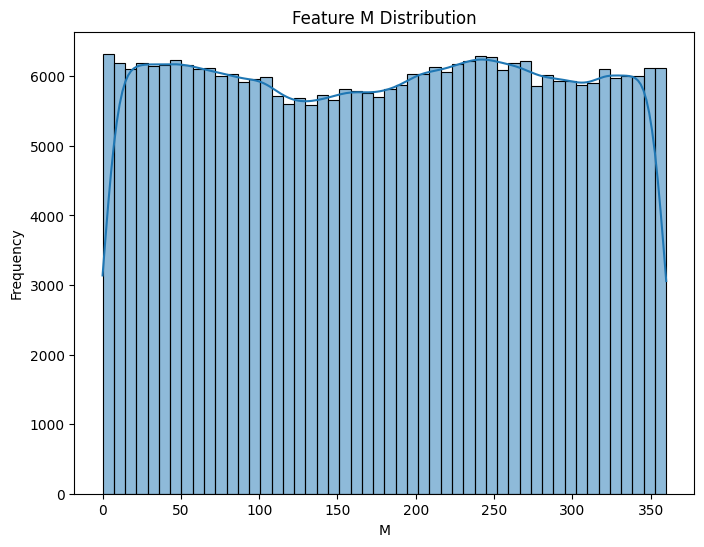

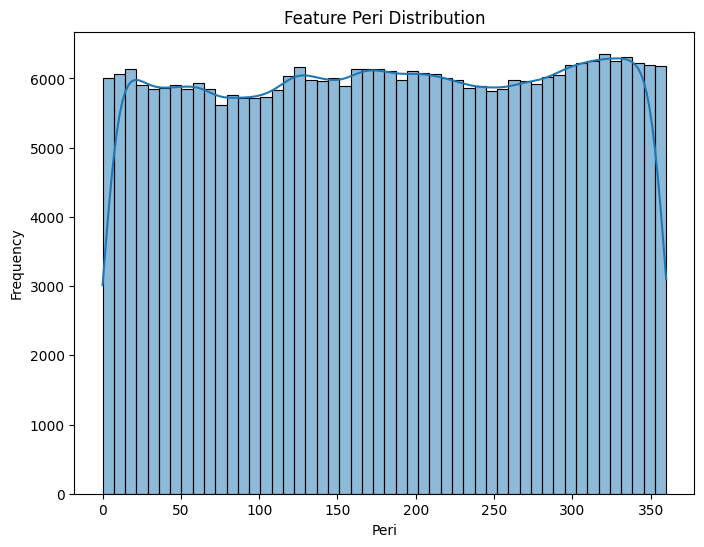

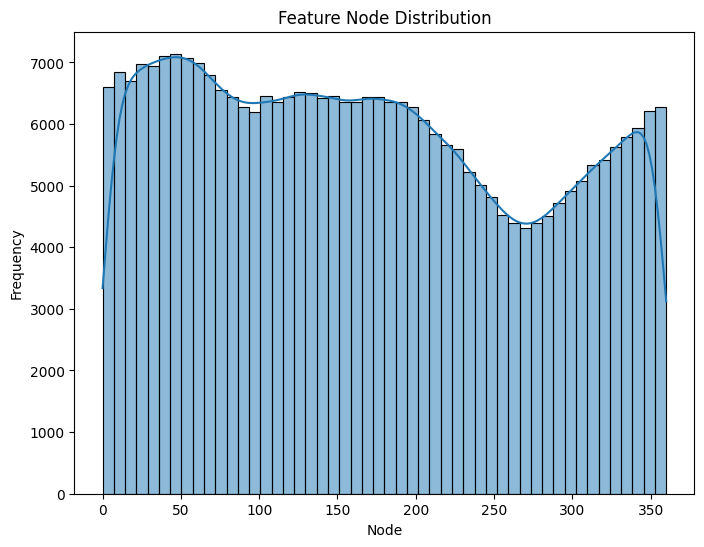

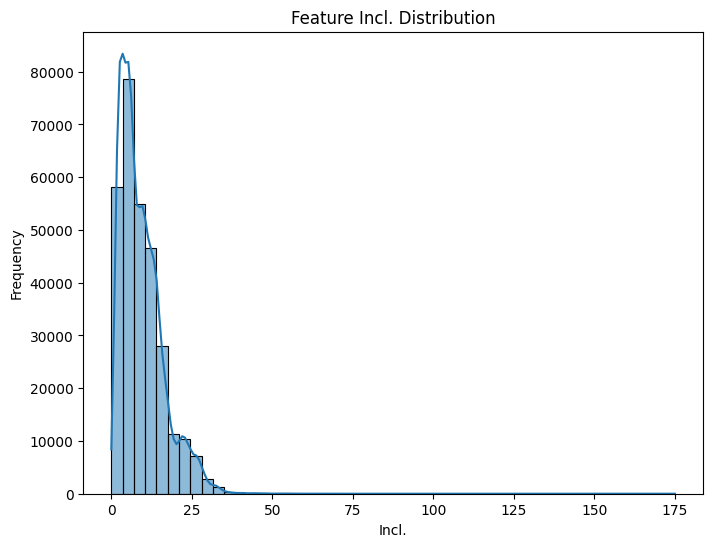

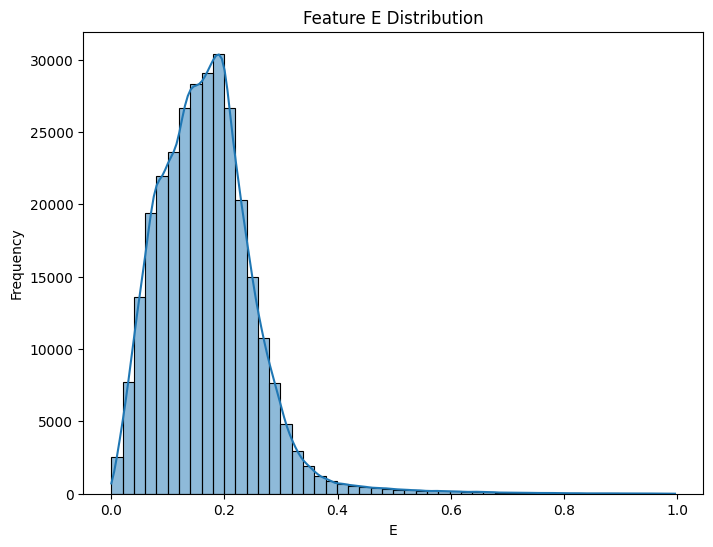

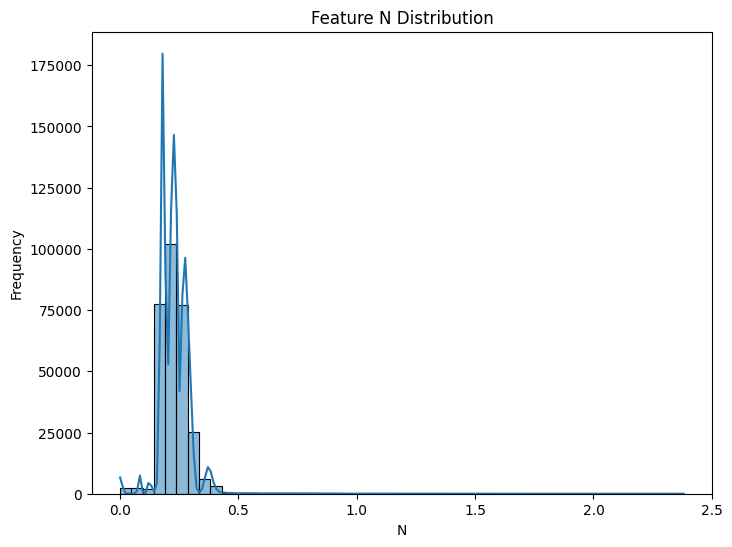

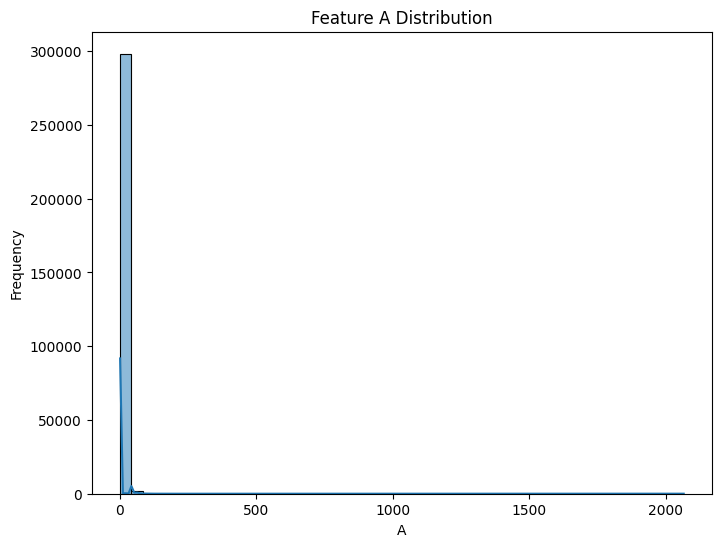

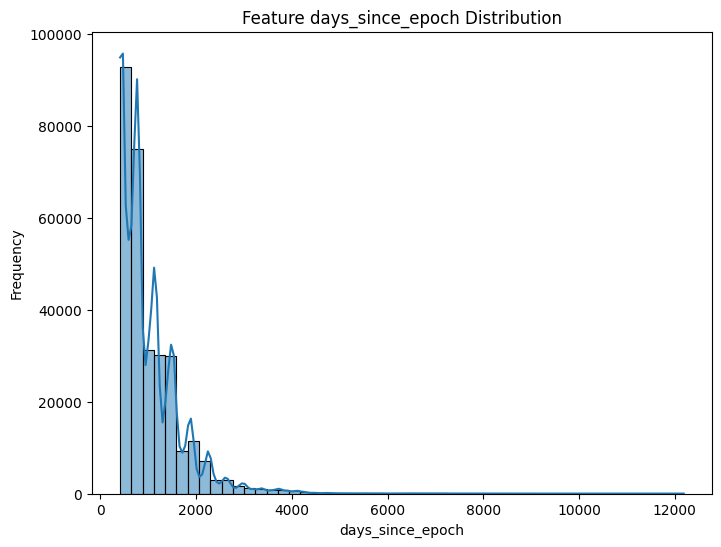

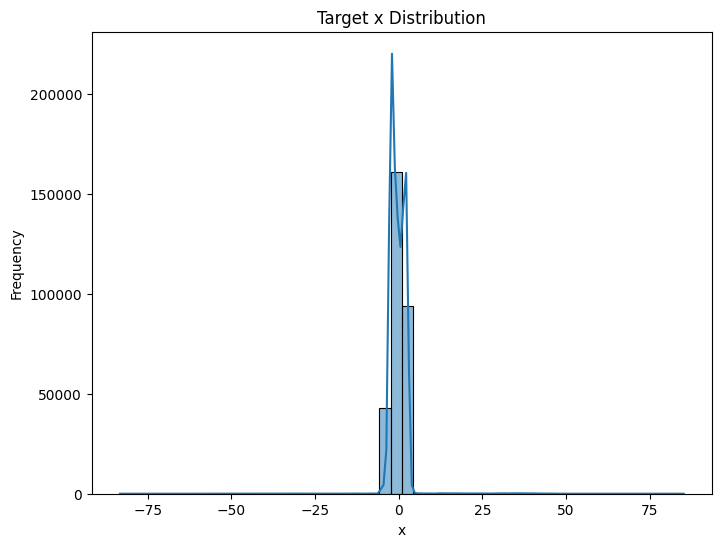

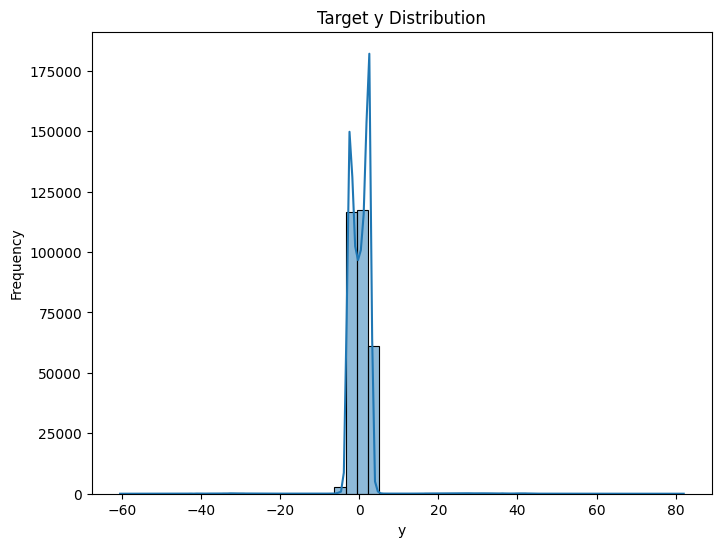

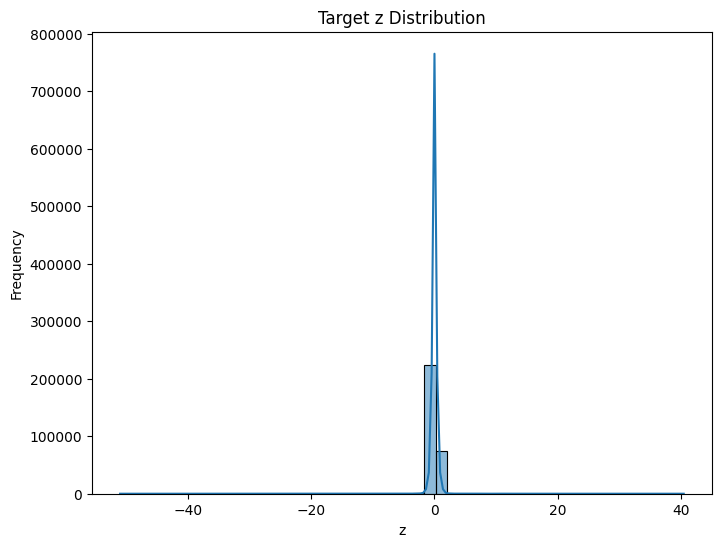

Özellikler ve hedef değişkenler arasındaki korelasyon:
                         x         y         z
M                -0.005822  0.053241  0.002509
Peri             -0.004378  0.009403  0.078329
Node             -0.011045 -0.003167 -0.015272
Incl.             0.029834  0.021170 -0.063529
E                -0.053937 -0.005710 -0.031686
N                -0.067449 -0.045727  0.059404
A                 0.164706  0.118120 -0.181509
days_since_epoch  0.041342 -0.048970 -0.043060


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Özellikler ve hedefler
feature_names = ["M", "Peri", "Node", "Incl.", "E", "N", "A", "days_since_epoch"]
target_names = ["x", "y", "z"]

# Özelliklerin dağılımını görselleştir
for i, feature in enumerate(feature_names):
    plt.figure(figsize=(8, 6))
    sns.histplot(X[:, i], bins=50, kde=True)
    plt.title(f"Feature {feature} Distribution")
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Hedef değişkenlerin dağılımını görselleştir
for i, axis in enumerate(target_names):
    plt.figure(figsize=(8, 6))
    sns.histplot(y_2026[:, i], bins=50, kde=True)
    plt.title(f"Target {axis} Distribution")
    plt.xlabel(axis)
    plt.ylabel('Frequency')
    plt.show()

# Özellikler (X) ve hedefler (y) arasındaki korelasyonu hesaplayalım
df_features = pd.DataFrame(X, columns=feature_names)
df_targets = pd.DataFrame(y_2026, columns=target_names)

# Özellikler ve hedefler arasındaki korelasyon
correlation_matrix = df_features.corrwith(df_targets["x"]).to_frame(name="x")
correlation_matrix["y"] = df_features.corrwith(df_targets["y"])
correlation_matrix["z"] = df_features.corrwith(df_targets["z"])

print("Özellikler ve hedef değişkenler arasındaki korelasyon:")
print(correlation_matrix)
